# Small Experiment Data Analysis

In [31]:
CWD = %pwd
CWD = str(CWD)
import sys
import json
from six.moves import cPickle
import os
import statistics
from collections import defaultdict,Iterable

from IPython.core.display import HTML 
from IPython.core.display import Image, display, display_pretty

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import PIL
# from PIL import Image
%matplotlib inline  


COCO_PATH = os.path.join(CWD,'data','coco')
COCO_ANNO_PATH = os.path.join(COCO_PATH, 'annotations')
COCO_TEXT_PATH = os.path.join(CWD, 'coco-text')
sys.path.insert(0, COCO_TEXT_PATH)
import coco_text as ct
ct = ct.COCO_Text(os.path.join(COCO_PATH, 'COCO_Text.json'))
import ablation

loading annotations into memory...
0:00:03.466757
creating index...
index created!


In [2]:
"""
Load Coco data
"""
COCO_PATH = 'data/coco/'
COCO_ANNO_PATH = COCO_PATH + 'annotations/'

# load the data from captions
with open(COCO_ANNO_PATH + 'captions_train2014.json') as f:
    coco_captions = json.load(f)
# print len(coco_captions)
# with open(COCO_ANNO_PATH + 'captions_val2014.json') as f:
#     coco_captions =  dict(coco_captions.items() + json.load(f).items())
# print len(coco_captions)

# build the reverse dictionary, from img_id to captions, img_infos, and annotations
img_captions = {}
for img_info in coco_captions['images']:
    mid = str(img_info['id'])
    if not mid in img_captions:
        img_captions[mid] = {}
    img_captions[mid]['image'] = img_info

for cap_info in coco_captions['annotations']:
    mid = str(cap_info['image_id'])
    if not 'annotation' in img_captions[mid]:
        img_captions[mid]['annotation'] = []
        img_captions[mid]['captions'] = []
    img_captions[mid]['annotation'].append(cap_info)


In [34]:
IN_FILE_NAME  = 'scores_no_rel_texts_blackout.pkl'
OUT_FILE_NAME = 'no_rel_texts_img_ids'
IN_DIR        = 'input'
OUT_DIR       = 'output'

def pre_process_vis(vis, scores, l):
    """Since with large batch size, vis.json might contain duplicates. This function will purge out the duplicates.
    l is the number of image ids used to generate vis. After filtering, vis should have length 2l."""
    surplus = len(vis)-2*l
    return vis[:-surplus], scores[:-(surplus/2)]

def get_stat(data):
    if len(data)==0: return;
    print ""
    print "Total:\t%d;\t\tMean:\t\t%f;\tNonezero:\t%d"%(len(data), statistics.mean(data), len(filter(lambda x:x!=0, data)))
    print "Median:\t%f;\tMedian(H):\t%f;\tMedian(L):\t%f;"%(statistics.median(data), statistics.median_high(data), statistics.median_low(data))
    print "Max:\t%f;\tMin:\t\t%f;\tStd:\t\t%f"%(max(data), min(data),statistics.stdev(data))
    print "\n"
    
def look_up_image(title, img_id, logs):
    print "[%s]%s\n"%(img_id,title)
    print "\tScore:%s;\n"%(logs[img_id]['score'])
    print "\tOriginal Caption:\n\t\t%s;\n\tAblation Caption:\n\t\t%s;"%(logs[img_id]['orig'], logs[img_id]['ablt'])
    print "\tAnnotated Captions:\n"
    for i, note in enumerate(img_captions[img_id]['annotation']):
        print "\t\t%d. %s\n"%(i+1, str(note['caption']).strip())
    
    ablt_meth = logs['ablation_method'] if 'ablation_method' in logs else 'blackout'
    [(_,orig_img , ablt_img)]  = ablation.gen_ablation(imgIds = [int(img_id)], mode = ablt_meth, ct=ct, ksize=(7,7),sigma=5.)
    plt.figure(int(img_id), figsize=(15,30))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.subplot(1,2,2)
    plt.imshow(ablt_img)
    plt.show()

def get_expr_summary(log_file='', in_path=IN_DIR, out_path=OUT_DIR, num=3):
    logs = cPickle.load(open(os.path.join(OUT_DIR, log_file)))
    scores = [(k,x['score']) for k, x in logs.iteritems() if isinstance(x,dict)]
    get_stat(map(lambda x: x[1], scores))

    sorted_scores_idx = sorted(scores, key=lambda x: x[1])   # sort by score
    for idx, _ in sorted_scores_idx[:num]:
        look_up_image("Images with lowest scores:",idx, logs)




Total:	15980;		Mean:		0.902979;	Nonezero:	15942
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.227583


[252779]Images with lowest scores:

	Score:0.0;

	Original Caption:
		a group of buses parked in a parking lot;
	Ablation Caption:
		a city street filled with lots of traffic;
	Annotated Captions:

		1. A row of buses parked behind a cross walk.

		2. A row of transit buses at a traffic light cross walk.

		3. Many busses and cars sit parked at a stop light

		4. An item inside the picture which appears to be truly astounding.

		5. An intersection is crowded with people, buses, and traffic.

Ablating image 1/1


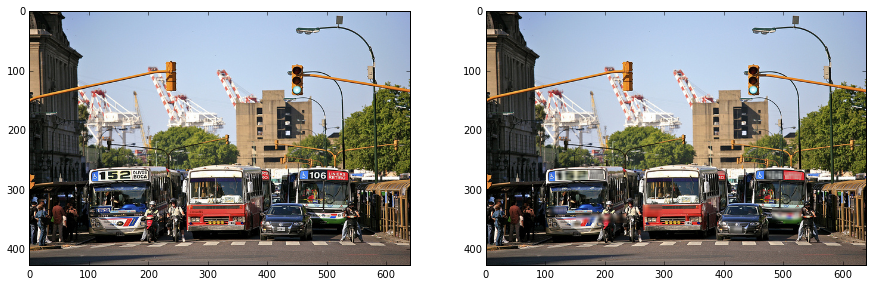

[491182]Images with lowest scores:

	Score:0.0;

	Original Caption:
		a clock on the side of a building;
	Ablation Caption:
		a statue of a man holding a teddy bear;
	Annotated Captions:

		1. A tree has clocks and a shopping cart hanging on it.

		2. There is a clock posted in the middle of town

		3. A shopping cart and clocks sit in a tree.

		4. A tree with many clocks hanging on it.

		5. A tree with several clocks hanging on it and a shopping cart in the limbs.

Ablating image 1/1


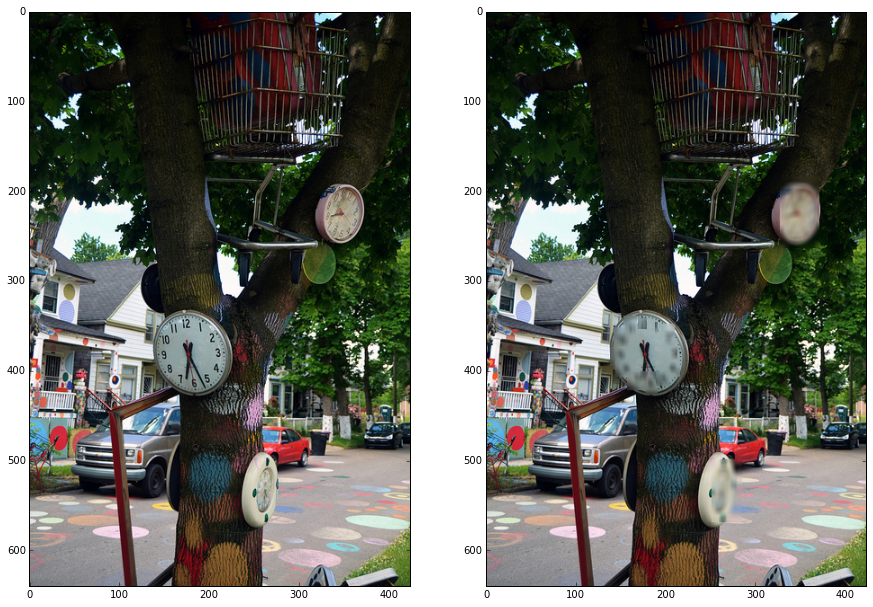

[33786]Images with lowest scores:

	Score:0.0;

	Original Caption:
		a street sign on the side of the road;
	Ablation Caption:
		a car is parked in front of a large building;
	Annotated Captions:

		1. A snow-covered area with a tree, cars, and a road sign.

		2. A snow covered street that has snow covered sidewalks and parked cars next to a street sign.

		3. A white and black street sing covered in snow next to trees.

		4. A snow covered sign is in the foreground with trees behind it.

		5. a street sign partially covered in snow

Ablating image 1/1


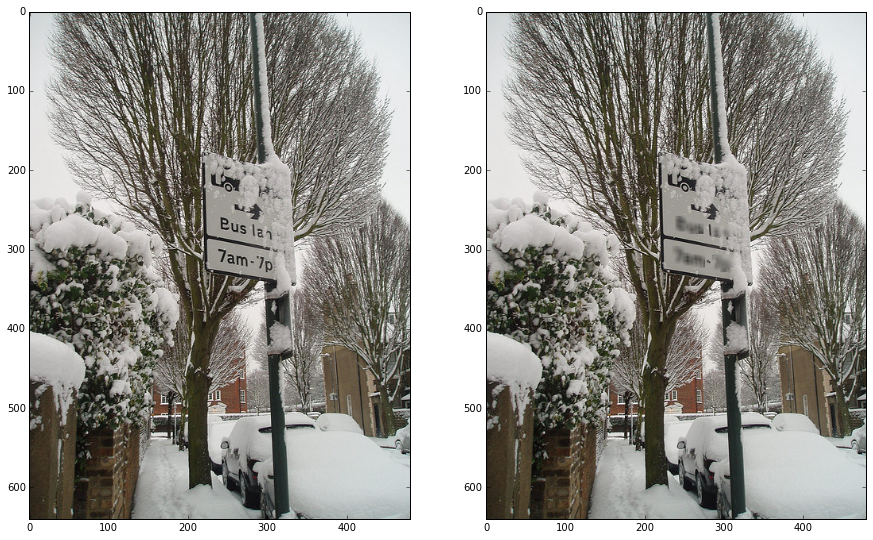

In [35]:
get_expr_summary(log_file='no_rel_gaussian.pkl')